In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imresize(img,scale=0.5):
    width,height = img.shape[0:2]
    new_width = np.round(scale*width).astype('int')
    new_height = np.round(scale*height).astype('int')
    scaled_img  = cv2.resize(img,(new_height,new_width))
    return scaled_img

In [3]:
from dataclasses import dataclass
@dataclass
class norm:
    x_mean: [float, float]
    y_mean: [float, float]
    x_scale: [float,float]
    y_scale: [float,float]
        


def norm2(x,y):
    x = np.float32(x)
    y= np.float32(y)
    n = x.shape[0]
    m = y.shape[0] 
    xmean = np.mean(x,axis=0)
    ymean = np.mean(y,axis=0)
    
    for i in range(len(x)):
        x[i,:] = x[i,:] - xmean
    for j in range(len(y)):
        y[j,:] = y[j,:] - ymean
        
    xscale = np.sqrt(np.sum(x*x)/n)
    yscale = np.sqrt(np.sum(y*y)/m)
    X = x/xscale
    Y = y/yscale
    normal = norm(xmean,ymean,xscale,yscale)
    return X,Y,normal
    

In [4]:
def con_K(x,y,beta):
    n = x.shape[0]
    m = y.shape[0]
    partA = np.tile(x[...,None],[1,1,m])
    partB = np.tile(y[...,None],[1,1,n])
    
    partB = np.transpose(partB, (2,1,0))
    K = partA - partB 
    K = np.squeeze(np.sum(K*K,axis=1))
    K = -beta * K
    K = np.exp(K)
   
    return K 


In [5]:


# def costfun_Manifold(param,X,Y,K,U,N0,lambda1,lambda2,sigma, is_grad,A):
#     C = np.reshape(param,(N0,2))
#     T = X + np.matmul(U,C)
#     F = np.exp(-np.sum(np.power(Y-T,2),axis=1)/sigma*sigma)
#     E = lambda1 * np.trace(np.matmul(C.T,np.matmul(K,C))) + lambda2 * np.trace(np.matmul(T.T,np.matmul(A,T))) - np.sum(F)    
#     matched_F = np.tile(F[...,None],[1,U.shape[1]])
#     part_a = U * matched_F
#     part_b = T-Y
#     tmp = np.matmul(part_a.T,part_b)
#     G = 2*lambda1*np.matmul(K,C) + 2*lambda2*np.matmul(U.T,np.matmul(A,T)) + (2*tmp/(sigma*sigma))
#     G = G.ravel()
#     return E
def jacobian(param,X,Y,K,U,N0,lambda1,lambda2,sigma, is_grad,A):
    C = np.reshape(param,(N0,2))
    T = X + np.matmul(U,C)
    F = np.exp(-np.sum(np.power(Y-T,2),axis=1)/sigma*sigma)
#     E = lambda1 * np.trace(np.matmul(C.T,np.matmul(K,C))) + lambda2 * np.trace(np.matmul(T.T,np.matmul(A,T))) - np.sum(F)    
    matched_F = np.tile(F[...,None],[1,U.shape[1]])
    part_a = U * matched_F
    part_b = T-Y
    tmp = np.matmul(part_a.T,part_b)
    G = 2*lambda1*np.matmul(K,C) + 2*lambda2*np.matmul(U.T,np.matmul(A,T)) + (2*tmp/(sigma*sigma))
    G = G.ravel()
    return G

def cost_function(param,X,Y,K,U,N0,lambda1,lambda2,sigma, is_grad,A):
    C = np.reshape(param,(N0,2))
    T = X + np.matmul(U,C)
    F = np.exp(-np.sum(np.power(Y-T,2),axis=1)/sigma*sigma)
    E = lambda1 * np.trace(np.matmul(C.T,np.matmul(K,C))) + lambda2 * np.trace(np.matmul(T.T,np.matmul(A,T))) - np.sum(F)    
    return E
    

In [35]:
from scipy.optimize import minimize
def GFEMR(X, Y, beta, lambda1, lambda2, anneal, sigma0, iter_num, N0, is_grad=1):
    N = X.shape[0]
    idx = np.random.permutation(N)
    idx=idx[0:int(np.min([N0,N]))]
    ctrl_X = X[idx,:]
   
    K = con_K(ctrl_X,ctrl_X,beta)
   
    U = con_K(X,ctrl_X,beta)
    x0=np.zeros((N0*2,1))
    sigma= sigma0
    #compute graph laplacian matrix
    r = 0.05
    X2 = np.sum(X*X,axis=1)
    distance = np.tile(X2[...,None],[1,N]) + np.tile(X2.T[None,...],[N,1]) -2*np.matmul(X,X.T)
    index = np.argwhere(distance<r)
    W = np.zeros((N,N))
    for i,j in index:
        W[i,j] = np.exp(-distance[i,j]/r)
    Dia = np.sum(W,axis=1)
    A = np.diag(Dia)-W
#     solve = minimize(costfun_Manifold,x0,args=(X,Y,K,U,N0,lambda1,lambda2,sigma,is_grad,A))
    solve = minimize(cost_function,x0,args=(X,Y,K,U,N0,lambda1,lambda2,sigma,is_grad,A),jac=jacobian)
    
    C = solve.x 
    C = np.reshape(C,(N0,2))
    V = X + np.matmul(U,C)
    return V


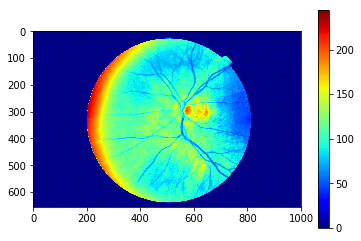

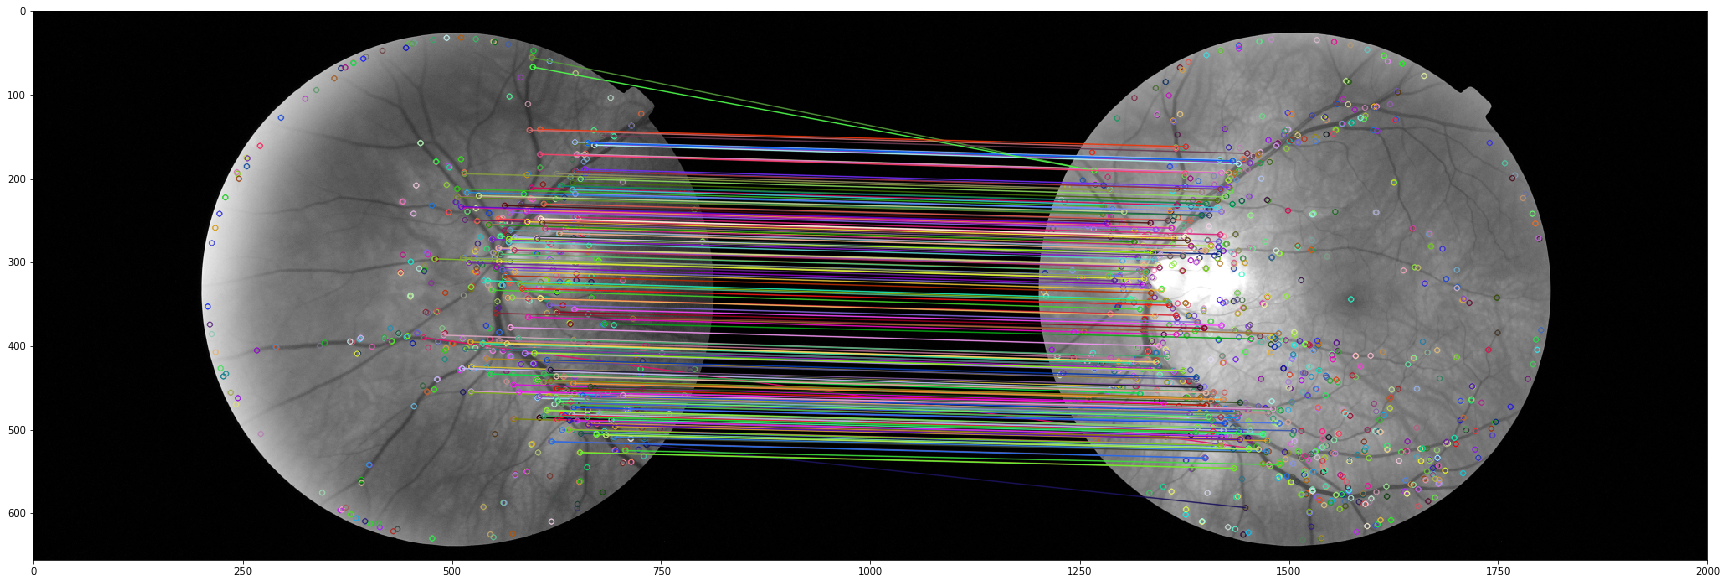

In [36]:
Im1= cv2.imread('110_a.png')
Im2 = cv2.imread('110_b.png')
mask = cv2.imread('mask.png',0)

Im1 = np.float32(Im1[:,:,1])
Im2 = np.float32(Im2[:,:,1])
Im1 = Im1/np.max(Im1)
Im2 = Im2/np.max(Im2)
Im1 = np.uint8(Im1*255)
Im2 = np.uint8(Im2*255)
mask = imresize(mask)
mask[mask < 255]= 0 

Im1 = imresize(Im1)
Im2 = imresize(Im2)
plt.imshow(Im1,'jet')
plt.colorbar()

kaze = cv2.KAZE_create(extended = True,threshold=0.0002,nOctaves=3)
kp1,des1 = kaze.detectAndCompute(Im1,mask)
kp2,des2 = kaze.detectAndCompute(Im2,mask)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
        
match_img = cv2.drawMatchesKnn(Im1,kp1,Im2,kp2,good,None)
plt.figure(figsize=(30,30))
plt.imshow(match_img)
## Parameters
iter_num = 1;   #iter number of deterministic annealing
anneal = 0.93;  #annealing rate
sigma0 = 0.3;   #sigma_0
N0 = 15;        #for fast implementation. N0<<N
is_grad = 1;
beta = 0.01;
lambda1 = 0.1;
lambda2 = 0.1;
threshold=0.01; #threshold to remove outliers
normalize = 1;  #normalize X (coordinates of feature points in I1) and Y (in I2)
# normal.xm=0; normal.ym=0;
# normal.xscale=1; normal.yscale=1;
src_pts = [ kp1[m[0].queryIdx].pt for m in good ]
dst_pts = [ kp2[m[0].trainIdx].pt for m in good ]
# # #convert to numpy arreay
X = np.array(src_pts)
Y = np.array(dst_pts)
X[:,[1,0]] = X[:,[0,1]]
Y[:,[1,0]] = Y[:,[0,1]]
nX,nY,normal = norm2(X,Y)
nV= GFEMR(nX, nY, beta, lambda1, lambda2, anneal, sigma0, iter_num, N0)

In [37]:
V  = nV * normal.y_scale
for i in range(len(V)):
    V[i,:] += normal.y_mean


In [38]:
delta=np.sum(np.power(nY-nV,2),axis=1);

In [39]:
idx = np.argwhere(delta<threshold)

In [40]:
new_match = []
for i in idx:
    new_match.append(good[i[0]])

In [41]:
match_img = cv2.drawMatchesKnn(Im1,kp1,Im2,kp2,new_match,None)

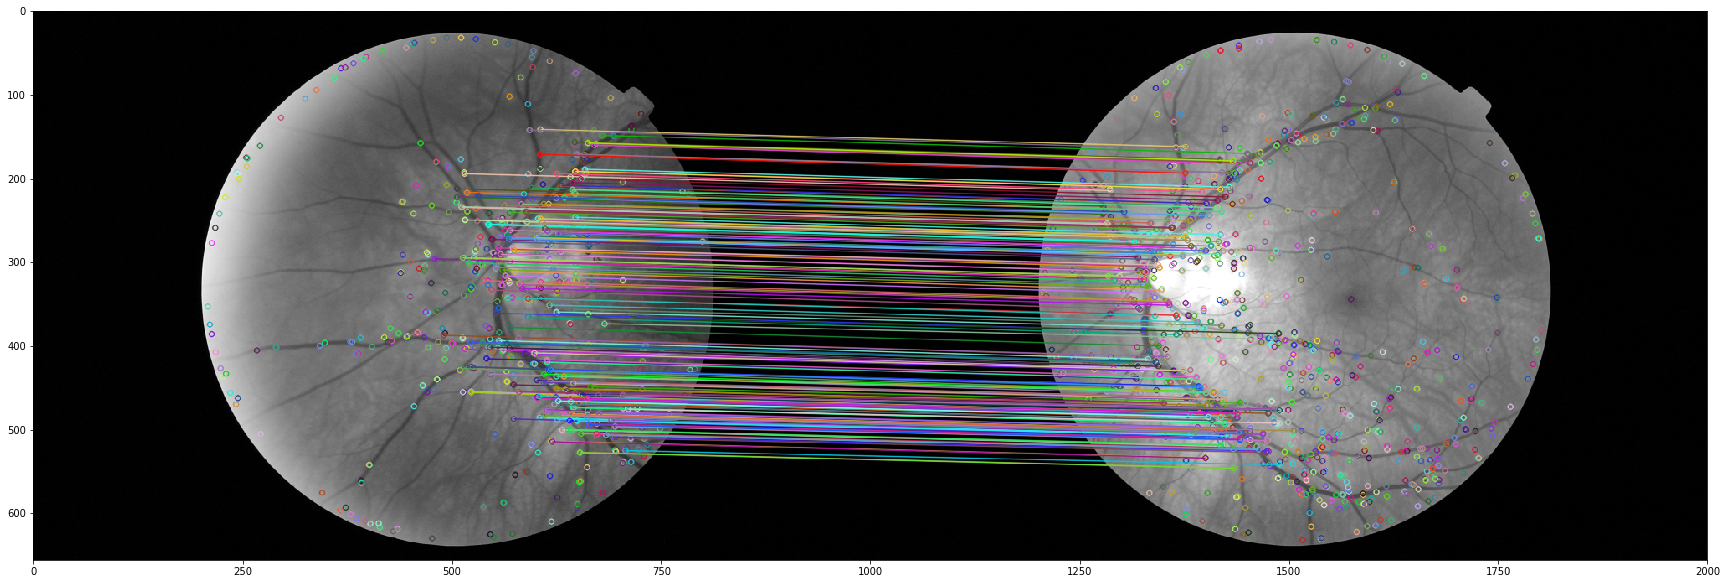

In [42]:
plt.figure(figsize=(30,30))
plt.imshow(match_img)

In [43]:
new_src_pts = [ kp1[m[0].queryIdx].pt for m in new_match ]
new_dst_pts = [ kp2[m[0].trainIdx].pt for m in new_match ]

In [44]:
new_src_pts = np.array(new_src_pts)
new_dst_pts = np.array(new_dst_pts)

In [31]:
H, __ = cv2.findHomography(new_src_pts, new_dst_pts, cv2.RANSAC, 5)

In [32]:
dst = cv2.warpPerspective(Im1,H,(Im1.shape[1] + Im2.shape[1], Im1.shape[0]))

In [33]:
dst[0:Im1.shape[0], 0:Im1.shape[1]] = Im2

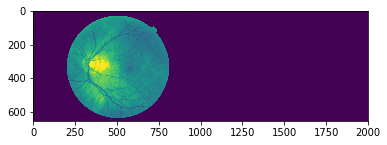

In [34]:
plt.imshow(dst)